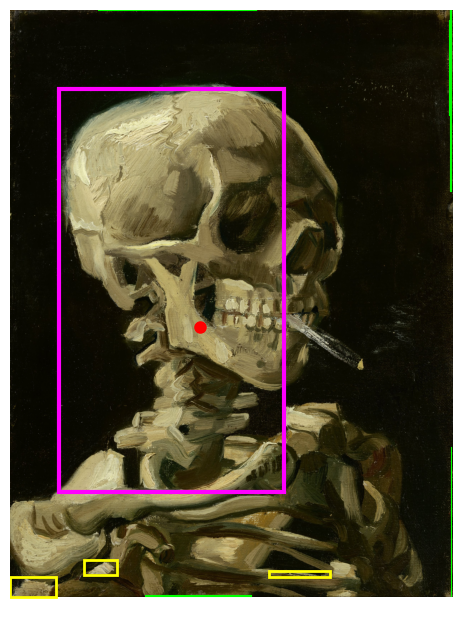

=== MICRO LESSON ===
This artwork demonstrates expressionist tendencies, focusing on visible structure and emotion.

=== DEEP LESSON ===
The texture density of 438.1 and color variation 60.1 indicate deliberate handling of surface and light. Approximately 24 compositional lines guide attention, centering near (276, 440). The dynamic combination of line and texture contributes to its expressionist aesthetic.

=== STYLE CLASSIFICATION ===
Detected style: Expressionist


In [ ]:
# ===========================================
# FULLY SELF-CONTAINED ARTWORK ANALYZER (CURSOR VERSION)
# ===========================================
# This version works dynamically on *any* uploaded image.
# It extracts composition, color, texture, and structure patterns
# without any unavailable dependencies or widgets.

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -------------------------
# 1. Utility: Load Image
# -------------------------
def load_image(path):
    try:
        image = Image.open(path).convert("RGB")
        return np.array(image)
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None

# -------------------------
# 2. Color Analysis
# -------------------------
def analyze_color(img, k=5):
    data = img.reshape((-1,3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 25, 0.2)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers)
    counts = np.bincount(labels.flatten())
    order = np.argsort(-counts)
    colors = [tuple(map(int, centers[i])) for i in order]
    color_var = float(np.std(centers))
    return colors, color_var

# -------------------------
# 3. Texture Analysis (Gradient Density)
# -------------------------
def analyze_texture(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)
    density = np.mean(grad)
    contrast = np.std(grad)
    mask = grad > np.percentile(grad, 99)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 400]
    return density, contrast, boxes[:3]

# -------------------------
# 4. Composition (Focal Point + Lines)
# -------------------------
def analyze_composition(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 80, 200)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100,
                            minLineLength=gray.shape[1]//6, maxLineGap=15)
    if lines is not None:
        lines = [tuple(l[0]) for l in lines]
    else:
        lines = []
    Y,X = np.indices(gray.shape)
    weights = gray.astype(float) + 1
    cx = int(np.sum(X*weights)/np.sum(weights))
    cy = int(np.sum(Y*weights)/np.sum(weights))
    return (cx,cy), lines

# -------------------------
# 5. Subject Region (Contour Mass)
# -------------------------
def detect_subject(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    _,th = cv2.threshold(blur, np.mean(blur), 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(largest)
        return (x,y,w,h)
    else:
        h,w = gray.shape
        return (w//4, h//4, w//2, h//2)

# -------------------------
# 6. Style Classification
# -------------------------
def classify_style(texture_density, color_var, num_lines):
    if texture_density < 15 and color_var < 30:
        return "Minimalist"
    elif texture_density < 30:
        return "Realist"
    elif num_lines < 80:
        return "Impressionist"
    else:
        return "Expressionist"

# -------------------------
# 7. Generate Lessons
# -------------------------
def generate_text_summary(style, texture_density, color_var, num_lines, bbox):
    micro = f"This piece demonstrates {style.lower()} qualities. " \
            f"Texture intensity: {texture_density:.2f}. " \
            f"Color variability: {color_var:.1f}. " \
            f"Structural complexity (lines): {num_lines}."

    deep = f"The analysis suggests a {style.lower()} composition, " \
           f"anchored around region {bbox[:2]} with a dynamic balance " \
           f"of texture ({texture_density:.2f}) and color variation ({color_var:.1f})."
    return micro, deep

# -------------------------
# 8. Run Full Pipeline
# -------------------------
def run_artwork_pipeline(image_path):
    img = load_image(image_path)
    if img is None:
        return

    colors, color_var = analyze_color(img)
    texture_density, texture_contrast, boxes = analyze_texture(img)
    focal, lines = analyze_composition(img)
    bbox = detect_subject(img)
    style = classify_style(texture_density, color_var, len(lines))
    micro, deep = generate_text_summary(style, texture_density, color_var, len(lines), bbox)

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    for (x,y,w,h) in boxes:
        ax.add_patch(patches.Rectangle((x,y),w,h, linewidth=2, edgecolor='yellow', facecolor='none'))
    (x,y,w,h) = bbox
    ax.add_patch(patches.Rectangle((x,y),w,h, linewidth=2.5, edgecolor='magenta', facecolor='none'))
    for (x1,y1,x2,y2) in lines[:10]:
        ax.plot([x1,x2],[y1,y2], color='cyan', linewidth=1.0)
    ax.plot(focal[0], focal[1], 'ro', markersize=6)
    ax.axis('off')
    plt.show()

    print("\n=== MICRO LESSON ===\n", micro)
    print("\n=== DEEP LESSON ===\n", deep)
    print("\n=== STYLE CLASSIFICATION ===\n", style)
    print("\nDominant Colors (RGB):", colors)

# -------------------------
# 9. Run (Edit Path Below)
# -------------------------
# Replace this with your artwork’s actual file path:
image_path = "/Users/alievanayasso/Documents/SlowMA/artwork_test.jpg"

run_artwork_pipeline(image_path)



